In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score
from scipy.stats import chisquare
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

In [2]:
expression_sc = pd.read_csv("/Users/adr/Box/Molecular_SysBio/projects/ENLIGHT-TEN+/Constance Le Gac/Useful_data/CAR_data/log_sc_expr_with_celltypes.csv")  
expression_sc


,Unnamed: 0,CD28,PI3K,Lck,Grb2,GADS,Akt,ERK12,GSK3b,CD3z,...,ADORA2A,TNFRSF4,KIR3DL1,GZMA,CD3E,RELA,IL16,CAR_Variant,Type,cell_type
0,AAACGAAAGGTAAGGA-1-1,0.217948,0.396791,0.900622,1.081187,0.396791,0.548449,0.000000,0.217948,1.483719,...,0.0,0.000000,0.0,1.887223,0.680107,0.217948,0.680107,h4-1BB_h4-1BB,CD8,CD8 Cytox/Memory
1,AAACGAAGTACGCGTC-1-1,0.000000,0.000000,0.000000,1.348236,1.902295,0.000000,0.000000,0.000000,0.000000,...,0.0,1.348236,0.0,2.724785,1.348236,0.000000,1.348236,h4-1BB_hIL15RA,CD8,CD8 Effector A
2,AAACGCTGTGTTCCAA-1-1,0.000000,0.000000,1.290507,1.133884,1.133884,0.719717,0.423257,0.000000,1.290507,...,0.0,0.000000,0.0,0.000000,1.835658,0.719717,1.133884,hIL15RA_hCD28,CD4,CD4 activated
3,AAAGAACGTTACCTTT-1-1,0.000000,0.000000,0.790086,0.790086,1.651070,0.000000,0.471124,0.471124,1.651070,...,0.0,0.000000,0.0,3.456047,1.388534,0.790086,1.031539,hIL15RA_hCTLA-4,CD8,CD8 Effector HLAhigh
4,AAAGGATAGTCTTCCC-1-1,0.164862,0.000000,0.960528,0.889473,1.026868,0.000000,0.812979,0.000000,1.482827,...,0.0,0.000000,0.0,0.164862,1.147646,0.306353,0.639827,hCTLA-4_hCD40,CD4,CD4 activated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4746,TTGTTGTTCCTAGCCT-1-TCR,0.000000,0.401374,1.243976,0.401374,1.243976,0.000000,0.908915,0.000000,0.908915,...,0.0,0.000000,0.0,2.473616,1.494505,0.401374,0.000000,TCR-,CD8,CD8 Effector HLAhigh
4747,TTGTTTGTCTATGCCC-1-TCR,0.000000,0.000000,1.908627,0.000000,0.000000,0.000000,0.000000,1.069735,1.908627,...,0.0,0.000000,0.0,2.524740,2.524740,0.000000,0.000000,TCR-,CD8,CD8 Effector HLAhigh
4748,TTTACCAGTCTGTGAT-1-TCR,0.000000,1.253120,0.000000,1.253120,0.000000,0.000000,0.811208,0.000000,0.811208,...,0.0,0.811208,0.0,1.558539,1.981433,0.000000,0.000000,TCR-,CD4,CD4 Memory
4749,TTTACGTTCACTTTGT-1-TCR,0.259640,0.000000,1.215419,1.377413,0.782006,0.000000,0.636254,0.465573,1.299693,...,0.0,0.000000,0.0,2.599087,0.782006,0.465573,0.465573,TCR-,CD8,CD8 Effector HLAhigh


In [3]:


# For each different vector, get the associated class vector
def encode_cell_function(celltype, cell_function_list):
    """
        Transform a cell-type into an int.
        Args:
            - celltype: celltype to encore
            - cell_function_list: sorted list of possible cell functions.
            Its indexing will serve to encode the celltype.
    """
    return(cell_function_list.index(celltype))



def encode_domain(domain_name):
    """
         Compute one-hot encoding of CAR variant on 10 bits.
         Use alphabetical order of CAR domains: 41BB, CD28, CD40, CTLA4, IL15RA.
         The first 5 bits represent the first domain, the last 5 bits the second.
         When there is only one domain it is encoded on the first 5 bits.
         0 everywhere is TCR-
    """
    CAR_variant = domain_name.split("_")
    domains = ["h4-1BB", "hCD28", "hCD40", "hCTLA-4", "hIL15RA"] # The h is an artefact (of scanpy?)
    l = len(CAR_variant)
    encoding = [0,0,0,0,0,0,0,0,0,0]
    if l>1:
        index_1 = domains.index(CAR_variant[0])
        encoding[index_1] = 1
        if "NA" not in CAR_variant[1]:
            index_2 = domains.index(CAR_variant[1])
            encoding[index_2 + 5] = 1
    return(pd.Series(encoding))

def encode_domain_with_pos(domain_name):
    """
     Compute one-hot encoding of CAR variant on 20 bits.
     Use alphabetical order of CAR domains: 41BB, CD28, CD40, CTLA4, IL15RA.
     For the ith domain: 
         + the i*4th position represents whether this domain is present or not.
         + the i*4+1th position represents whether this domain is the only domain of the variant
         + the i*4+2 and i*4+3 position represent whther the domain is present in the 1st or 2nd position 
             in the case where there are 2 domains.
     0 everywhere is TCR-
    """
    CAR_variant = domain_name.split("_")
    domains = ["h4-1BB", "hCD28", "hCD40", "hCTLA-4", "hIL15RA"] # The h is an artefact (of scanpy?)
    l = len(CAR_variant)
    encoding = [0]*20
    if l>1:
        index_1 = domains.index(CAR_variant[0])
        encoding[index_1*4] = 1
        if "NA" not in CAR_variant[1]:
            index_2 = domains.index(CAR_variant[1])
            encoding[index_1*4+2] = 1 # domain 1 is present in 1st position 
            encoding[index_2*4] = 1
            encoding[index_2*4+3] = 1 # domain 2 is present in 2nd position
        else: # There is only one domain
            encoding[index_1*4+1] = 1 # domain 1 is present alone
    return(pd.Series(encoding))

In [4]:
def get_training_and_test_sets(TF_expression, training_list):
    """
        Split the dataset in a train and a test set, as well as a validation set.
        The train set will contain all cells with input domains contained in training_list except the validation set
        The validation set will contain a couple single cells with CAR variants present in the training set
        Args:
            - TF_expression: a dataset of single cell data relating CAR_Variant to cell_type
            (needs to ne single-cell since one CAR variant can lead to several celltypes and we need to
            learn the probability)
            - training_list: list of CAR_variants to use in the training set. By default, all non specified
            CAR variants will go into the test set
    """
    TF_training = pd.DataFrame()
    TF_test = pd.DataFrame()
    training = []
    test = []
    for i in range(len(TF_expression)):
        curr_row = pd.Series(TF_expression.loc[i])
        if curr_row["CAR_Variant"] in training_list:
            training.append(i)
        else:
            test.append(i)
    TF_training = TF_expression.iloc[training]
    TF_test = TF_expression.iloc[test]
    return(TF_training, TF_test)

def get_validation_set(training_set, proportion):
    validation_set = pd.DataFrame()
    # Get the validation set = 1/proportion of training set:
    for car in list(np.unique(training_set["CAR_Variant"])):
        CAR_training = training_set[training_set["CAR_Variant"]==car]
        if len(CAR_training)>2: # If I have at least 2 cell in the training set, so that I can use one for validation
            sample_size = int(np.floor(len(CAR_training)/proportion))
            indices = list(CAR_training.index[0:sample_size])
            validation_set = pd.concat([validation_set, CAR_training.loc[indices]])
            training_set = training_set.drop(indices)
    return(training_set, validation_set)

In [5]:
# Create the 2 different encoding

encoding_simple = expression_sc["CAR_Variant"].apply(encode_domain)
encoding_with_pos = expression_sc["CAR_Variant"].apply(encode_domain_with_pos)

encoding_simple["CAR_Variant"] = expression_sc["CAR_Variant"]
encoding_simple["function_encoded"] = expression_sc["cell_type"].apply(encode_cell_function,
                                                                      cell_function_list = sorted(np.unique(expression_sc["cell_type"])))
encoding_simple["Type"] = expression_sc["Type"]
encoding_simple["cell_type"] = expression_sc["cell_type"]

encoding_with_pos["CAR_Variant"] = expression_sc["CAR_Variant"]
encoding_with_pos["function_encoded"] = expression_sc["cell_type"].apply(encode_cell_function,
                                                                cell_function_list = sorted(np.unique(expression_sc["cell_type"])))
encoding_with_pos["Type"] = expression_sc["Type"]
encoding_with_pos["cell_type"] = expression_sc["cell_type"]

In [6]:
# Define the "core" training domains that should always be present in the training set
training_list_core =  ["TCR-",
                 "h4-1BB_h4-1BB", 
                 "h4-1BB_NA", 
                 "hCD28_hCD28", 
                 "hCD28_NA",
                 "hCD40_hCD40", 
                 "hCD40_NA", 
                 "hCTLA-4_hCTLA-4",
                 "hCTLA-4_NA",
                 "hIL15RA_hIL15RA",
                 "hIL15RA_NA"
                ]

other_domains = list(np.unique(expression_sc["CAR_Variant"]))
for i,c in enumerate (training_list_core):
    other_domains.remove(c)

In [7]:
def compare_proba_to_freq(df, test, test_CD4, test_CD8, predicted_proba_test_CD4, predicted_proba_test_CD8):
    #### Compare predicted probabilities to observed frequencies ###
    results_df = pd.DataFrame()
    for car in list(np.unique(test["CAR_Variant"])):
        for i in range(8):
            celltype_list = sorted(np.unique(df["cell_type"]))
            celltype = celltype_list[i]
            if i <4:
                CD_type = "CD4"
                res = predicted_proba_test_CD4
                # res["CAR Variant"] contains the probability of having each CD4 celltype for this CAR variant
                if len(res[res["CAR_Variant"]== car][i])==0:
                    proba = 0
                else:
                    proba = float(res[res["CAR_Variant"]== car][i])
                true = test_CD4
            else:
                CD_type = "CD8"
                res = predicted_proba_test_CD8
                if len(res[res["CAR_Variant"]== car][i-4])==0:
                    proba = 0 
                else:
                    proba = float(res[res["CAR_Variant"]== car][i-4])
                
                true = test_CD8
                
            # Observed frequency
            df_CAR = true[true["CAR_Variant"] == car]
            if len(df_CAR)==0: # hCTLA-4_h4-1BB only has CD4 cells (4 of them)
                # This adds a spurious (0,0) point but it should not influence the results much
                freq = 0
            else:
                freq = len(df_CAR[df_CAR["cell_type"]==celltype])/len(df_CAR)
            results_df = results_df.append(pd.Series([car, CD_type, celltype, proba, freq]), ignore_index=True)

    results_df.columns= ["CAR Variant", "Type", "Cell type", "Predicted probability", "True frequency"]
    return(results_df)

In [8]:
def get_predicted_class(test, y_pred_test_CD4, y_pred_test_CD8, test_CD4, test_CD8):
    predictions = pd.DataFrame()
    for car in list(np.unique(test["CAR_Variant"])):
        # All cells with the same CAR are predicted the same celltype
        predicted_class_CD4 = float(y_pred_test_CD4[y_pred_test_CD4["CAR_Variant"]==car][0])
        # Value counts order by descending order
        majority_class_CD4 = test_CD4[test_CD4["CAR_Variant"]==car]["function_encoded"].value_counts().index[0]

        predictions = predictions.append(pd.Series([car, "CD4", predicted_class_CD4, majority_class_CD4]), ignore_index=True)
        
        if car in y_pred_test_CD8["CAR_Variant"]:
            predicted_class_CD8 = float(y_pred_test_CD8[y_pred_test_CD8["CAR_Variant"]==car][0])
            majority_class_CD8 = test_CD8[test_CD8["CAR_Variant"]==car]["function_encoded"].value_counts().iloc[0]
            
            predictions = predictions.append(pd.Series([car, "CD8", predicted_class_CD8, majority_class_CD8]), ignore_index=True)
    predictions.columns = ["CAR Variant", "Type", "Predicted class", "Majority class"]
    return(predictions)

In [9]:
def prepare_train_test_and_val_sets(df, training_list, encoding, plot = True):
    if encoding == "simple":
        df = encoding_simple
    else:
        df = encoding_with_pos
    
    train, test = get_training_and_test_sets(df, training_list)
    
    train_CD4 = train[train["Type"] =="CD4"]
    test_CD4 = test[test["Type"] =="CD4"]
    train_CD4, validation_CD4 = get_validation_set(train_CD4, 10)
    
    train_CD8 = train[train["Type"] =="CD8"]
    test_CD8 = test[test["Type"] =="CD8"]
    train_CD8, validation_CD8 = get_validation_set(train_CD8, 10)

    if plot:
        # Plot the comparison of the frequencies between training set and validation set
         # For debugging purposes, compare frequencies in the training and validation set
        freq_CD4 = pd.DataFrame()
        for car in sorted(np.unique(train_CD4["CAR_Variant"])):
            for celltype in sorted(np.unique(df["cell_type"]))[0:4]:
                train_CAR_CD4 = train_CD4[train_CD4["CAR_Variant"] == car]
                freq_train_CD4 = len(train_CAR_CD4[train_CAR_CD4["cell_type"]==celltype])/(len(train_CAR_CD4)+0.0001)
                val_CAR_CD4 = validation_CD4[validation_CD4["CAR_Variant"] == car]
                freq_val_CD4 = len(val_CAR_CD4[val_CAR_CD4["cell_type"]==celltype])/(len(val_CAR_CD4)+0.0001)
                freq_CD4 = freq_CD4.append(pd.Series([car, celltype, freq_train_CD4, freq_val_CD4]), ignore_index=True)
        freq_CD4.columns = ["CAR", "celltype", "Train freq", "Val freq"]
        sns.relplot(data = freq_CD4, x = "Train freq", y = "Val freq")

        freq_CD8= pd.DataFrame()
        for car in sorted(np.unique(train_CD8["CAR_Variant"])):
            for celltype in sorted(np.unique(df["cell_type"]))[4:8]:
                train_CAR_CD8 = train_CD8[train_CD8["CAR_Variant"] == car]
                freq_train_CD8 = len(train_CAR_CD8[train_CAR_CD8["cell_type"]==celltype])/(len(train_CAR_CD8)+0.0001)
                val_CAR_CD8 = validation_CD8[validation_CD8["CAR_Variant"] == car]
                freq_val_CD8 = len(val_CAR_CD8[val_CAR_CD8["cell_type"]==celltype])/(len(val_CAR_CD8)+0.0001)
                freq_CD8 = freq_CD8.append(pd.Series([car, celltype, freq_train_CD8, freq_val_CD8]), ignore_index=True)
        freq_CD8.columns = ["CAR", "celltype", "Train freq", "Val freq"]
        sns.relplot(data = freq_CD8, x = "Train freq", y = "Val freq")
    
    print(len(freq_CD4), len(freq_CD8))
    return(train, test, train_CD4, test_CD4, validation_CD4, train_CD8, test_CD8, validation_CD8)



In [34]:
def train_and_report_logistic_regression(df, training_list, encoding, maxiter):
    """
        This uses a multinomial logistic regression with L2-regularisation with the default penalty terms.
    """
    train, test, train_CD4, test_CD4, validation_CD4, train_CD8, test_CD8, validation_CD8  = prepare_train_test_and_val_sets(df, training_list, encoding)
    
    if encoding == "simple":
        predictor_cols = [i for i in range(10)]
    else:
        predictor_cols = [i for i in range(20)]
    
    ############ DO THE TRAINING ON CD4 #############################
    grid_CD4 = GridSearchCV(estimator= LogisticRegression(multi_class = "multinomial", random_state = 2), 
                            param_grid = {"penalty":[None, "l1", "l2", "elasticnet"], 
                                          "C": [10, 1, 0.1, 0.01, 0.001],
                                          "solver":["lbfgs", "saga"],
                                          "max_iter": [500, 1000]
                                         }, 
                           refit=True, 
                            verbose = 4)
    grid_CD4.fit(X = train_CD4[predictor_cols],
               y = train_CD4["function_encoded"])
    rf_CD4 = grid_CD4.best_estimator_
    
    # We don't predict on single cell but per CAR Variant
    y_pred_test_CD4 = pd.DataFrame(rf_CD4.predict(X = test_CD4[predictor_cols]))
    y_pred_test_CD4["CAR_Variant"]=test_CD4[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols+["CAR_Variant"]).count().reset_index()["CAR_Variant"]
    
    predicted_proba_test_CD4 = pd.DataFrame(
        rf_CD4.predict_proba(
            X = test_CD4[predictor_cols].groupby(predictor_cols).count().reset_index()))
    predicted_proba_test_CD4["CAR_Variant"] = test_CD4[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols+["CAR_Variant"]).count().reset_index()["CAR_Variant"]
    

    ########### THEN DO THE SAME ON CD8 ########################
    grid_CD8 = GridSearchCV(estimator= LogisticRegression(multi_class = "multinomial", random_state = 2), 
                            param_grid = {"penalty":[None, "l1", "l2", "elasticnet"], 
                                          "C": [10, 1, 0.1, 0.01, 0.001],
                                          "solver":["lbfgs", "saga"],
                                          "max_iter": [500, 1000]
                                         }, 
                           refit=True, 
                            verbose = 4)
    grid_CD8.fit(X = train_CD8[predictor_cols],
               y = train_CD8["function_encoded"])
    rf_CD8 = grid_CD8.best_estimator_
    print(grid_CD8.best_params_)
    
    # We don't predict by single cell but per CAR variant
    y_pred_test_CD8 = pd.DataFrame(rf_CD8.predict(X = test_CD8[predictor_cols]))
    y_pred_test_CD8["CAR_Variant"]=test_CD8[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols+["CAR_Variant"]).count().reset_index()["CAR_Variant"]
    predicted_proba_test_CD8 = pd.DataFrame(
        rf_CD8.predict_proba(
            X = test_CD8[predictor_cols].groupby(predictor_cols).count().reset_index()))
    predicted_proba_test_CD8["CAR_Variant"] = test_CD8[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols+["CAR_Variant"]).count().reset_index()["CAR_Variant"]
 
    results_df = compare_proba_to_freq(df,test, test_CD4, test_CD8, predicted_proba_test_CD4, predicted_proba_test_CD8)
    ### See if the predicted class is the majority class ###
    predictions = get_predicted_class(test, y_pred_test_CD4, y_pred_test_CD8, test_CD4, test_CD8)
    
    ## Then get the results and probabilities for the validation set
    y_pred_val_CD4 = pd.DataFrame(rf_CD4.predict(X = validation_CD4[predictor_cols]))
    y_pred_val_CD4["CAR_Variant"]=validation_CD4[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols+["CAR_Variant"]).count().reset_index()["CAR_Variant"]
    
    predicted_proba_val_CD4 = pd.DataFrame(
        rf_CD4.predict_proba(
            X = validation_CD4[predictor_cols].groupby(predictor_cols).count().reset_index()))
    predicted_proba_val_CD4["CAR_Variant"] = validation_CD4[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols+["CAR_Variant"]).count().reset_index()["CAR_Variant"]

    y_pred_val_CD8 = pd.DataFrame(rf_CD8.predict(X = validation_CD8[predictor_cols]))
    y_pred_val_CD8["CAR_Variant"]=validation_CD8[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols+["CAR_Variant"]).count().reset_index()["CAR_Variant"]
    
    predicted_proba_val_CD8 = pd.DataFrame(
        rf_CD8.predict_proba(
            X = validation_CD8[predictor_cols].groupby(predictor_cols).count().reset_index()))
    predicted_proba_val_CD8["CAR_Variant"] = validation_CD8[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols+["CAR_Variant"]).count().reset_index()["CAR_Variant"]
    
    val_df = pd.concat([validation_CD4, validation_CD8], ignore_index=True)
    results_val = compare_proba_to_freq(df, val_df, validation_CD4, validation_CD8, predicted_proba_val_CD4, predicted_proba_val_CD8)
    
   
    return(results_df, predictions, results_val )
            

[5, 1, 13, 4, 8]
104 100
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 1/5]

/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.477 total time=   0.3s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.454 total time=   0.1s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.439 total time=   0.1s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.425 total time=   0.1s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.430 total time=   0.1s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.484 total time=   0.1s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.454 total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.439 total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.425 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.430 total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.484 total time=   0.0s
[CV 1

[CV 2/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.437 total time=   0.0s
[CV 3/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.430 total time=   0.0s
[CV 4/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.430 total time=   0.0s
[CV 5/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.477 total time=   0.0s
[CV 1/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.454 total time=   0.0s
[CV 2/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.437 total time=   0.0s
[CV 3/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.425 total time=   0.0s
[CV 4/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.440 total time=   0.0s
[CV 5/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.484 total time=   0.0s
[CV 1/5] END C=1, max_iter=1000, penalty=l2, solver=saga;, score=0.454 total time=   0.0s
[CV 2/5] END C=1, max_iter=1000, penalty=l2, solver=saga;, score=0.437 total time=   0.0s
[CV 3

[CV 5/5] END C=0.01, max_iter=500, penalty=l1, solver=saga;, score=0.411 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.415 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.402 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.457 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.430 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.516 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.415 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.402 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.457 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.430 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.516 to

[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, solver=saga;, score=0.406 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, solver=saga;, score=0.413 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5

/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklear

[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.720 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.624 total time=   0.1s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.643 total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.631 total time=   0.1s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.720 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.741 total time=   0.1s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.624 total time=   0.1s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.643 total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.631 total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.720 total time=   0.0s
[CV 4

[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.741 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.624 total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=elasticnet, solve

[CV 1/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.643 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.631 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.720 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.467 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.624 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=1000, penalty=el

[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.485 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.482 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.482 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.482 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.484 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, solver=saga;, score=0.485 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, solver=saga;, score=0.482 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, solver=saga;, score=0.482 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, solver=saga;, score=0.482 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, solver=saga;, score=0.484 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=1000, penalty=elasticnet

/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/adr/miniconda3/envs/CAR_env/lib/python3.7/site-packages/sklear

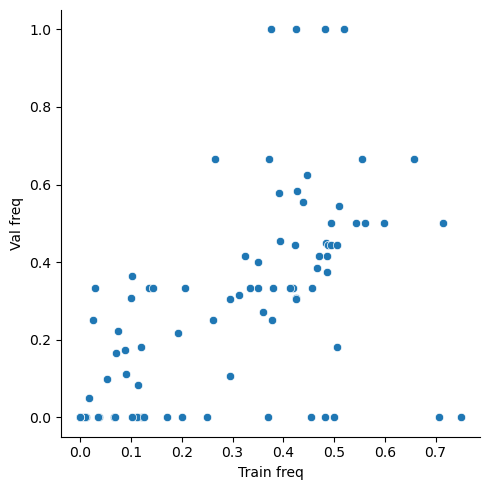

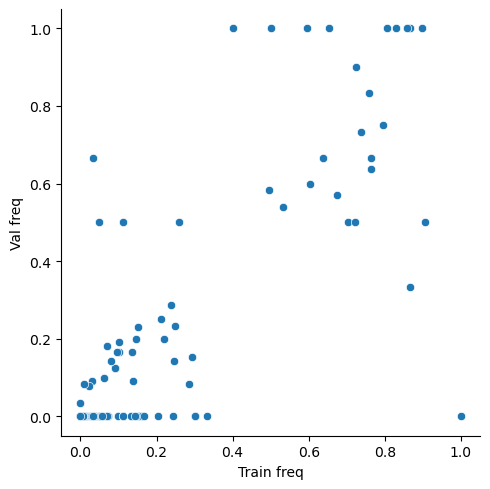

In [35]:
 # Choose domains
rng = np.random.default_rng(2)

indices = list(rng.choice(len(other_domains), 5, replace = False))
print(indices)
test_list = [other_domains[i] for i in indices]
training_list = training_list_core + [c for c in other_domains if c not in test_list]

res_1, predictions, results_val = train_and_report_logistic_regression(expression_sc, training_list, "simple", 500)

In [36]:
predictions

,CAR Variant,Type,Predicted class,Majority class
0,h4-1BB_hCD40,CD4,3.0,0.0
1,hCD28_h4-1BB,CD4,1.0,3.0
2,hCD28_hCD40,CD4,1.0,3.0
3,hCD40_h4-1BB,CD4,3.0,3.0
4,hCTLA-4_hCD28,CD4,1.0,1.0


In [37]:
results_val

,CAR Variant,Type,Cell type,Predicted probability,True frequency
0,TCR-,CD4,CD4 HLAhigh,0.243433,0.500000
1,TCR-,CD4,CD4 Memory,0.463928,0.450000
2,TCR-,CD4,CD4 Th2/Activated,0.001966,0.000000
3,TCR-,CD4,CD4 activated,0.290673,0.050000
4,TCR-,CD8,CD8 Cytox/Memory,0.249888,0.233333
...,...,...,...,...,...
195,hIL15RA_hIL15RA,CD4,CD4 activated,0.261283,0.217391
196,hIL15RA_hIL15RA,CD8,CD8 Cytox/Memory,0.285392,0.583333
197,hIL15RA_hIL15RA,CD8,CD8 Effector A,0.358076,0.083333
198,hIL15RA_hIL15RA,CD8,CD8 Effector HLAhigh,0.334227,0.250000


In [38]:
res_1

,CAR Variant,Type,Cell type,Predicted probability,True frequency
0,h4-1BB_hCD40,CD4,CD4 HLAhigh,0.217725,0.520710
1,h4-1BB_hCD40,CD4,CD4 Memory,0.414934,0.266272
2,h4-1BB_hCD40,CD4,CD4 Th2/Activated,0.001758,0.000000
3,h4-1BB_hCD40,CD4,CD4 activated,0.365583,0.213018
4,h4-1BB_hCD40,CD8,CD8 Cytox/Memory,0.543892,0.729412
5,h4-1BB_hCD40,CD8,CD8 Effector A,0.326808,0.082353
6,h4-1BB_hCD40,CD8,CD8 Effector HLAhigh,0.122772,0.152941
7,h4-1BB_hCD40,CD8,NK T cell,0.006529,0.035294
8,hCD28_h4-1BB,CD4,CD4 HLAhigh,0.090344,0.078947
9,hCD28_h4-1BB,CD4,CD4 Memory,0.388091,0.289474


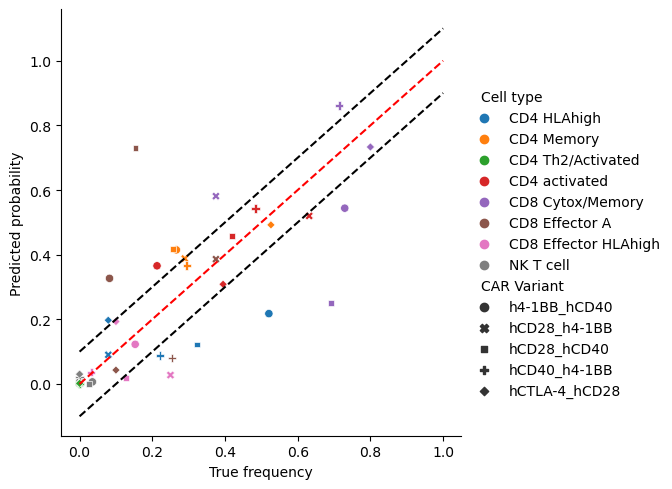

In [17]:

ident = np.linspace(0,1,100)
sns.relplot(x= "True frequency",
            y = "Predicted probability",
            style= "CAR Variant",
            hue="Cell type",
            data = res_1)
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

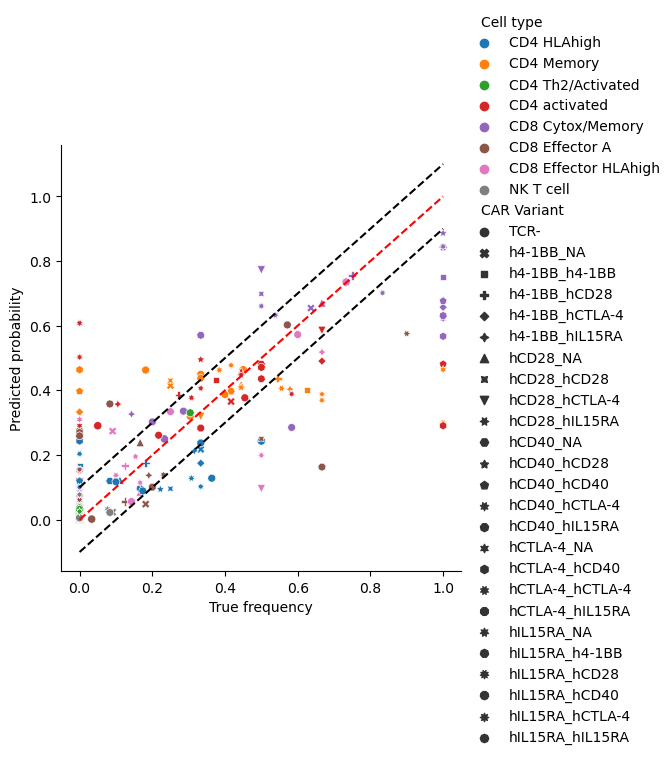

In [39]:

ident = np.linspace(0,1,100)
sns.relplot(x= "True frequency",
            y = "Predicted probability",
            style= "CAR Variant",
            hue="Cell type",
            data = results_val)
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

In [ ]:
# Now try with different test sets:

rng = np.random.default_rng(2)

res_list = []
pred_list = []
for i in range(10):
    indices = list(rng.choice(len(other_domains), 5, replace = False))
    print(indices)
    test_list = [other_domains[i] for i in indices]
    training_list = training_list_core + [c for c in other_domains if c not in test_list]
    
    res,predictions, res_val= train_and_report_logistic_regression(expression_sc, training_list, "with_pos", 500)
    res_list.append(res)
    pred_list.append(predictions)
    train, test, train_CD4, test_CD4, validation_CD4, train_CD8, test_CD8, validation_CD8  = prepare_train_test_and_val_sets(
        df, training_list, "with_pos")
    
    compute_pval(num_iter = 1000, CD_type="CD4",
             prediction_results_df = res,
             true_data_df = test_CD4, epsilon = 1e-6)
    compute_pval(num_iter = 1000, CD_type="CD8",
             prediction_results_df = res,
             true_data_df = test_CD8, epsilon = 1e-6)
    
res = pd.concat(res_list)
pred = pd.concat(pred_list)

ident = np.linspace(0,1,100)
sns.relplot(x= "True frequency",
            y = "Predicted probability",
            #style= "CAR Variant",
            hue="Cell type",
            data = res)
plt.plot(ident, ident, "--r")
plt.plot(ident, ident+0.1, "--k")
plt.plot(ident, ident-0.1, "--k")

In [18]:
def compute_likelihood(domain, CD_type, prediction_results_df, true_data_df, epsilon = 1e-6):
    # The likelihood is the product for each datapoint of the probability of having this celltype under
    # the predicted probability distribution
    """
        Args:
            - domain: the domain for which to compute the log-likelihood (the log-likelihood for all domains
                will later be summed in compute_likelihood_test_set)
            - CD_type: CD4 or CD8, needs to be specified as we have a different model for each
            - prediction_results_df: dataframe containing predicted celltype probabilities for each CAR
            - true_data_df: dataframe containing the true celltypes of the cells for which
                we want to compute the likelihood
            - epsilon: penalty to use when the true celltype has a 0 predicted probability
            
    """

    pred = prediction_results_df[prediction_results_df["CAR Variant"]==domain]
    true = true_data_df[true_data_df["CAR_Variant"]==domain]
    
    LL = 0
    N = 0
    #print(domain)
    for celltype in list(true[true["Type"]==CD_type]["cell_type"]): # For each observed cell type
        #print(celltype)
        p = float(pred[pred["Cell type"]==celltype]["Predicted probability"])
        #print(p)
        if p==0:
            LL += np.log(epsilon) # Cannot take log of 0, hence use epsilon <<1
        else:
            LL += np.log(p)
        N+=1
    
    return(LL, N)

def compute_likelihood_test_set(CD_type, predictions_results_df, true_data_df, epsilon = 1e-6):
    """
        Args:
            - CD_type: CD4 or CD8, needs to be specified as we have a different model for each
            - prediction_results_df: dataframe containing predicted celltype probabilities for each CAR
            - true_data_df: dataframe containing the true celltypes of the cells for which
                we want to compute the likelihood
            - epsilon: penalty to use when the true celltype has a 0 predicted probability
            
    """
    LL = 0
    N = 0
    predictions_results_df = predictions_results_df[predictions_results_df["Type"] == CD_type]
    #print(list(np.unique(true_data_df["CAR_Variant"])))
    for car in list(np.unique(true_data_df["CAR_Variant"])): # For the CARs that are in the test set
        
        LL_curr, N_curr = compute_likelihood(car, CD_type, predictions_results_df, true_data_df, epsilon)
        LL += LL_curr
        N+= N_curr
    return(LL) # Divide the loglikelihood by the number of points

In [19]:
def compute_pval_likelihood(CD_type, prediction_results_df, true_data_df, random_generator):
    """
        Args:
            - CD_type: CD4 or CD8, needs to be specified as we have a different model for each
            - prediction_results_df: dataframe containing predicted celltype probabilities for each CAR
            - true_data_df: dataframe containing the true celltypes of the cells for which
                we want to compute the likelihood. It is used here in order to determine and reproduce
                the repartition of the dataset in between different CAR variants.
            
    """
    LL = 0
    if CD_type == "CD4":
        types = sorted(np.unique(prediction_results_df["Cell type"]))[0:4]
    else: # CD8
        types = sorted(np.unique(prediction_results_df["Cell type"]))[4:8]
        
    true_data_df = true_data_df[true_data_df["Type"] == CD_type] # Only look at one CD type
    LL = 0
    batch_size = 0
    for car in true_data_df["CAR_Variant"]: 
        # For each cell that are in the observed sample I draw a cell with the same CAR 
        # (to have same CAR and CD-type distribution in my simulated batch than in my true observed sample)
        CAR_df = prediction_results_df[prediction_results_df["CAR Variant"] == car]
        # Get the probability for each cell type for the given CAR variant and CD type
        proba_vect = list(CAR_df[CAR_df["Cell type"].isin(types)]["Predicted probability"])
        
        draw = random_generator.choice(a  = [0,1,2,3], size = 1, p = proba_vect)[0]
        batch_size+=1
        
        # Compute the log likelihood of the batch
        LL += np.log(proba_vect[draw])
    #LL = LL/batch_size # Divide the loglikelihood by the number of points
    return(LL)

def compute_pval(CD_type, num_iter, prediction_results_df, true_data_df, epsilon=1e-6):
    rng = np.random.default_rng(2) # Reproducibility
    observed_LL = compute_likelihood_test_set(
        CD_type=CD_type,
        predictions_results_df = prediction_results_df,
        true_data_df = true_data_df,
        epsilon = epsilon)
    inferior = 0
    for i in range(num_iter):
        MC_LL = compute_pval_likelihood(CD_type = CD_type, true_data_df=true_data_df, prediction_results_df=prediction_results_df, random_generator = rng)
        if MC_LL<observed_LL:
            inferior+=1
        #print(MC_LL)
    print("OBSERVED:",  observed_LL)
    pval = inferior/num_iter
    return(pval)

The pvalue is around 0.5 in all cases when I assume that the model is that of the true frequencies.

[5, 1, 13, 4, 8]
104 100
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 1/5]

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.477 total time=   0.5s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.454 total time=   0.1s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.439 total time=   0.1s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.425 total time=   0.1s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.430 total time=   0.1s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.484 total time=   0.1s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.454 total time=   0.1s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.439 total time=   0.1s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.425 total time=   0.1s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.430 total time=   0.1s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.484 total time=   0.1s
[CV 1

[CV 1/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.454 total time=   0.0s
[CV 2/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.437 total time=   0.0s
[CV 3/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.430 total time=   0.0s
[CV 4/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.430 total time=   0.0s
[CV 5/5] END C=1, max_iter=1000, penalty=l1, solver=saga;, score=0.477 total time=   0.0s
[CV 1/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.454 total time=   0.0s
[CV 2/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.437 total time=   0.0s
[CV 3/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.425 total time=   0.0s
[CV 4/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.440 total time=   0.0s
[CV 5/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.484 total time=   0.0s
[CV 1/5] END C=1, max_iter=1000, penalty=l2, solver=saga;, score=0.454 total time=   0.0s
[CV 2

[CV 3/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.430 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.423 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.526 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=1000

[CV 2/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.390 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.411 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.411 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.411 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.400 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.412 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.411 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.406 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.413 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.400 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, sco

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
250 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib

{'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=None, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=None, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=None, solver=saga;,

[CV 1/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.643 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.631 total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.720 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.624 total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.643 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.631 total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.720 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.741 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.624 total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.643 total time=   0.0s
[CV 2/5] END C=1

[CV 2/5] END C=0.1, max_iter=1000, penalty=l1, solver=saga;, score=0.625 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=1000, penalty=l1, solver=saga;, score=0.720 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=l1, solver=saga;, score=0.467 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=l1, solver=saga;, score=0.624 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.643 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.631 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.720 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.467 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.624 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.643 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=l2, solver=saga;, score=0.631 to

[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.485 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.482 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.482 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.482 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.484 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.485 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.482 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.482 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.482 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.484 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=elasticnet, solver=lb

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
250 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ubuntu/storage/miniconda3/envs/work/lib

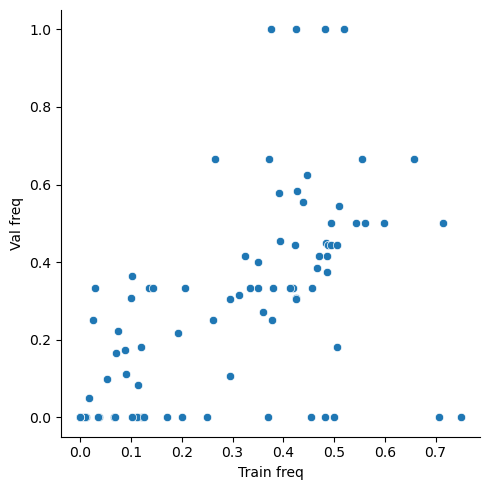

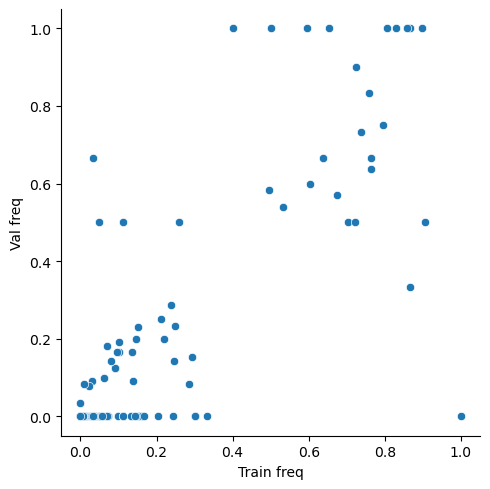

In [20]:
 # Choose domains
rng = np.random.default_rng(2)

indices = list(rng.choice(len(other_domains), 5, replace = False))
print(indices)
test_list = [other_domains[i] for i in indices]
training_list = training_list_core + [c for c in other_domains if c not in test_list]

res_1, predictions, results_val = train_and_report_logistic_regression(expression_sc, training_list, "simple", 500)

# This is inside train_and_report_logistic regression and we use it here to obtain the pvalues
# It is deterministic so we can just copy the code
train, test = get_training_and_test_sets(expression_sc, training_list)
    
train_CD4 = train[train["Type"] =="CD4"]
test_CD4 = test[test["Type"] =="CD4"]
train_CD4, validation_CD4 = get_validation_set(train_CD4, 10)

train_CD8 = train[train["Type"] =="CD8"]
test_CD8 = test[test["Type"] =="CD8"]
train_CD8, validation_CD8 = get_validation_set(train_CD8, 10)

In [21]:
compute_pval(num_iter = 1000, CD_type="CD4",
             prediction_results_df = res_1,
             true_data_df = test_CD4, epsilon = 1e-6)

OBSERVED: -501.59364780438193


0.0

In [22]:
compute_pval(num_iter = 1000, CD_type="CD8",
             prediction_results_df = res_1,
             true_data_df = test_CD8, epsilon = 1e-6)

OBSERVED: -227.23300092334216


0.0

In [23]:
compute_pval(num_iter=1000, CD_type = "CD4", prediction_results_df=results_val, 
            true_data_df=validation_CD4, epsilon=1e-6)

OBSERVED: -233.39136303422563


0.33

In [24]:
compute_pval(num_iter=1000, CD_type = "CD8", prediction_results_df=results_val, 
            true_data_df=validation_CD8, epsilon=1e-6)

OBSERVED: -154.72550501768936


0.362

In [25]:
res_1

,CAR Variant,Type,Cell type,Predicted probability,True frequency
0,h4-1BB_hCD40,CD4,CD4 HLAhigh,0.217725,0.520710
1,h4-1BB_hCD40,CD4,CD4 Memory,0.414934,0.266272
2,h4-1BB_hCD40,CD4,CD4 Th2/Activated,0.001758,0.000000
3,h4-1BB_hCD40,CD4,CD4 activated,0.365583,0.213018
4,h4-1BB_hCD40,CD8,CD8 Cytox/Memory,0.543892,0.729412
5,h4-1BB_hCD40,CD8,CD8 Effector A,0.326808,0.082353
6,h4-1BB_hCD40,CD8,CD8 Effector HLAhigh,0.122772,0.152941
7,h4-1BB_hCD40,CD8,NK T cell,0.006529,0.035294
8,hCD28_h4-1BB,CD4,CD4 HLAhigh,0.090344,0.078947
9,hCD28_h4-1BB,CD4,CD4 Memory,0.388091,0.289474


In [26]:
compute_likelihood("hCD28_h4-1BB", "CD8", res_1, test_CD8, epsilon = 1e-6)

(-11.660645066393622, 8)

In [27]:
test_CD4[test_CD4["CAR_Variant"] == "h4-1BB_hCD40"]

,Unnamed: 0,CD28,PI3K,Lck,Grb2,GADS,Akt,ERK12,GSK3b,CD3z,...,ADORA2A,TNFRSF4,KIR3DL1,GZMA,CD3E,RELA,IL16,CAR_Variant,Type,cell_type
5,AAAGGGCCAATTAGGA-1-1,0.388974,0.388974,1.065353,0.668307,0.886408,0.886408,1.065353,0.668307,1.065353,...,0.0,0.668307,0.0,1.465166,1.569392,0.668307,0.000000,h4-1BB_hCD40,CD4,CD4 HLAhigh
21,AACAACCAGAACGCGT-1-1,0.976338,0.000000,1.460806,1.323850,0.000000,0.439269,0.439269,0.439269,1.323850,...,0.0,2.100522,0.0,0.000000,0.976338,0.439269,0.439269,h4-1BB_hCD40,CD4,CD4 Memory
47,AAGAACAAGTTACTCG-1-1,0.000000,0.870748,0.870748,0.000000,0.870748,0.000000,0.000000,0.000000,1.642116,...,0.0,0.000000,0.0,1.329034,2.233468,0.000000,0.870748,h4-1BB_hCD40,CD4,CD4 Memory
88,AATTCCTTCCATTGTT-1-1,0.000000,0.945918,0.945918,1.212763,0.580867,0.000000,0.580867,0.580867,0.580867,...,0.0,0.000000,0.0,0.580867,1.423193,0.000000,1.212763,h4-1BB_hCD40,CD4,CD4 Memory
240,AGCTCAATCAGGAAAT-1-1,0.000000,0.256189,1.012320,0.459949,0.459949,0.000000,0.000000,0.000000,1.437928,...,0.0,0.256189,0.0,0.459949,1.437928,0.459949,0.629136,h4-1BB_hCD40,CD4,CD4 Memory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,TTCCACGCAGTGTGCC-1-2,0.763055,0.000000,1.719060,0.000000,0.763055,0.000000,0.000000,0.763055,1.489406,...,0.0,0.000000,0.0,0.000000,1.489406,0.000000,0.763055,h4-1BB_hCD40,CD4,CD4 Memory
4178,TTGCGTCAGAATTGTG-1-2,0.388958,0.000000,1.065322,0.886380,0.668284,0.886380,0.000000,0.000000,1.663735,...,0.0,0.886380,0.0,2.438841,1.217052,0.000000,0.000000,h4-1BB_hCD40,CD4,CD4 activated
4190,TTGGATGTCTACACAG-1-2,0.416327,0.229675,1.120220,1.032237,0.935759,0.229675,0.229675,0.416327,1.275896,...,0.0,1.032237,0.0,0.416327,1.275896,0.416327,0.000000,h4-1BB_hCD40,CD4,CD4 activated
4209,TTGTTGTCATGTCGTA-1-2,0.000000,0.000000,1.824637,1.281010,0.922999,0.500817,0.832969,0.196134,1.544093,...,0.0,0.196134,0.0,2.098110,1.005588,0.196134,0.832969,h4-1BB_hCD40,CD4,CD4 HLAhigh


In [28]:
p_effA = np.log(0.360738)
p_cytox = np.log(0.595432)
p_hla = np.log(0.035140)
p_nk = np.log(0.008690)

In [29]:
# Likelihood of my observed sample
p_effA+ p_cytox+p_effA+p_effA+ p_cytox+p_cytox+p_hla+p_hla

-11.311044689580724

In [30]:
# Likelihood of a draw
rng = np.random.default_rng(2)
p_vec = [0.360738,0.595432, 0.035140, 0.008690]
pval = 0
for i in range(500):
    ll=0
    draw = np.random.choice(a  = [0,1,2,3], size = 8, p = p_vec)
    for j in range(len(draw)):
        ll+=np.log(p_vec[draw[j]])
    print(ll)
    if ll<-11.311044689580724:
        pval+=1
print(pval/500)

-4.147744691707488
-7.154556248414958
-6.152285729512468
-5.651150470061223
-6.653420988963713
-8.982232839272218
-5.150015210609978
-9.377129463851379
-7.4788270609184835
-6.152285729512468
-5.150015210609978
-6.152285729512468
-5.651150470061223
-6.152285729512468
-5.651150470061223
-5.150015210609978
-5.651150470061223
-5.651150470061223
-9.878264723302625
-8.982232839272218
-5.150015210609978
-4.648879951158733
-6.152285729512468
-6.152285729512468
-6.152285729512468
-6.152285729512468
-8.982232839272218
-5.150015210609978
-5.651150470061223
-5.651150470061223
-5.651150470061223
-5.651150470061223
-4.648879951158733
-5.651150470061223
-5.651150470061223
-6.152285729512468
-5.651150470061223
-4.648879951158733
-5.150015210609978
-5.150015210609978
-9.878264723302623
-5.150015210609978
-6.152285729512468
-8.875994204400135
-7.154556248414958
-6.152285729512468
-5.651150470061223
-6.152285729512468
-7.979962320369728
-5.651150470061223
-8.481097579820974
-5.150015210609978
-6.15228572

In [31]:
res_1

,CAR Variant,Type,Cell type,Predicted probability,True frequency
0,h4-1BB_hCD40,CD4,CD4 HLAhigh,0.217725,0.520710
1,h4-1BB_hCD40,CD4,CD4 Memory,0.414934,0.266272
2,h4-1BB_hCD40,CD4,CD4 Th2/Activated,0.001758,0.000000
3,h4-1BB_hCD40,CD4,CD4 activated,0.365583,0.213018
4,h4-1BB_hCD40,CD8,CD8 Cytox/Memory,0.543892,0.729412
5,h4-1BB_hCD40,CD8,CD8 Effector A,0.326808,0.082353
6,h4-1BB_hCD40,CD8,CD8 Effector HLAhigh,0.122772,0.152941
7,h4-1BB_hCD40,CD8,NK T cell,0.006529,0.035294
8,hCD28_h4-1BB,CD4,CD4 HLAhigh,0.090344,0.078947
9,hCD28_h4-1BB,CD4,CD4 Memory,0.388091,0.289474


In [32]:
# With a bigger set
observed_ll =compute_likelihood("h4-1BB_hCD40", "CD4", res_1, test_CD4, epsilon = 1e-6)
observed_ll

(-209.966890520461, 169)

In [33]:
# Likelihood of a draw
rng =np.random.default_rng(2)
p_vec = [0.181386,0.459762, 0.000130, 0.358722]
pval = 0
for i in range(500):
    ll=0
    draw = rng.choice(a  = [0,1,2,3], size = 169, p = p_vec)
    for j in range(len(draw)):
        ll+=np.log(p_vec[draw[j]])
    print(ll)
    if ll<-222.10196874722584:
        pval+=1
print(pval/500)

-173.86478908969465
-174.11295033873301
-178.39216265423698
-174.91999747491002
-176.09614802382967
-165.06029551685833
-174.67183622587171
-185.1508951529144
-181.67872997358748
-177.64558659991178
-180.74864836649624
-180.06463570123324
-169.46254230327642
-175.60191783296304
-169.3395078323623
-176.96575854906897
-173.49568567695218
-169.08925427611388
-182.98000730063134
-174.1755137277951
-173.12030534257948
-172.37582159546452
-180.49839481024785
-175.10559533488635
-182.29808694257838
-178.14400140519862
-172.25487943176037
-165.8652503458254
-172.0671892645741
-179.81647445219483
-181.9894546116879
-164.874697656882
-171.19757873933486
-177.52255212899766
-179.19920979041407
-179.9416012303191
-173.61662784065624
-167.1686199800793
-181.7392010554395
-182.54624819161666
-180.1271990902953
-174.67183622587174
-175.91055016385334
-173.8022257006325
-176.9657585490689
-177.6476789071219
-172.50094837358867
-170.3926239103677
-176.46943605099221
-169.58557677419057
-177.58511551805

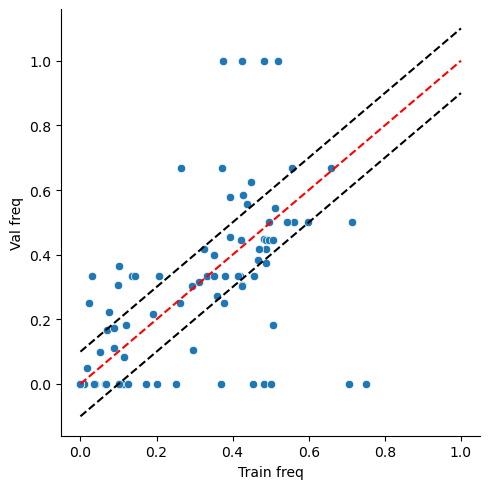

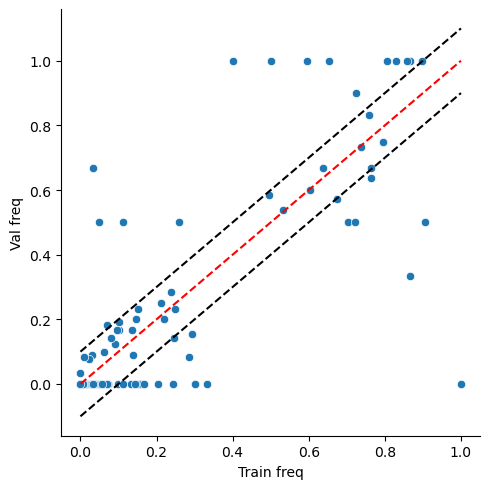

In [34]:

ident = np.linspace(0,1,100)
# See how well the models learnt the training set
df = expression_sc
freq_CD4 = pd.DataFrame()
for car in sorted(np.unique(train_CD4["CAR_Variant"])):
    for celltype in sorted(np.unique(df["cell_type"]))[0:4]:
        train_CAR_CD4 = train_CD4[train_CD4["CAR_Variant"] == car]
        freq_train_CD4 = len(train_CAR_CD4[train_CAR_CD4["cell_type"]==celltype])/(len(train_CAR_CD4)+0.0001)
        val_CAR_CD4 = validation_CD4[validation_CD4["CAR_Variant"] == car]
        freq_val_CD4 = len(val_CAR_CD4[val_CAR_CD4["cell_type"]==celltype])/(len(val_CAR_CD4)+0.0001)
        freq_CD4 = freq_CD4.append(pd.Series([car, celltype, freq_train_CD4, freq_val_CD4]), ignore_index=True)
freq_CD4.columns = ["CAR", "celltype", "Train freq", "Val freq"]
sns.relplot(data = freq_CD4, x = "Train freq", y = "Val freq")
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

freq_CD8= pd.DataFrame()
for car in sorted(np.unique(train_CD8["CAR_Variant"])):
    for celltype in sorted(np.unique(df["cell_type"]))[4:8]:
        train_CAR_CD8 = train_CD8[train_CD8["CAR_Variant"] == car]
        freq_train_CD8 = len(train_CAR_CD8[train_CAR_CD8["cell_type"]==celltype])/(len(train_CAR_CD8)+0.0001)
        val_CAR_CD8 = validation_CD8[validation_CD8["CAR_Variant"] == car]
        freq_val_CD8 = len(val_CAR_CD8[val_CAR_CD8["cell_type"]==celltype])/(len(val_CAR_CD8)+0.0001)
        freq_CD8 = freq_CD8.append(pd.Series([car, celltype, freq_train_CD8, freq_val_CD8]), ignore_index=True)
freq_CD8.columns = ["CAR", "celltype", "Train freq", "Val freq"]


sns.relplot(data = freq_CD8, x = "Train freq", y = "Val freq")
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

In [35]:
# Then compare predicted proba to training frequencies

freq_CD4.index = freq_CD4[["CAR", "celltype"]]
freq_CD4

,CAR,celltype,Train freq,Val freq
"(TCR-, CD4 HLAhigh)",TCR-,CD4 HLAhigh,0.494444,0.499998
"(TCR-, CD4 Memory)",TCR-,CD4 Memory,0.483333,0.449998
"(TCR-, CD4 Th2/Activated)",TCR-,CD4 Th2/Activated,0.005556,0.000000
"(TCR-, CD4 activated)",TCR-,CD4 activated,0.016667,0.050000
"(h4-1BB_NA, CD4 HLAhigh)",h4-1BB_NA,CD4 HLAhigh,0.135135,0.333331
...,...,...,...,...
"(hIL15RA_hCTLA-4, CD4 activated)",hIL15RA_hCTLA-4,CD4 activated,0.705880,0.000000
"(hIL15RA_hIL15RA, CD4 HLAhigh)",hIL15RA_hIL15RA,CD4 HLAhigh,0.088785,0.173912
"(hIL15RA_hIL15RA, CD4 Memory)",hIL15RA_hIL15RA,CD4 Memory,0.294392,0.304347
"(hIL15RA_hIL15RA, CD4 Th2/Activated)",hIL15RA_hIL15RA,CD4 Th2/Activated,0.425233,0.304347


In [36]:
results_val = results_val[results_val["Type"]=="CD4"]
results_val.index = results_val[["CAR Variant", "Cell type"]]
results_val

,CAR Variant,Type,Cell type,Predicted probability,True frequency
"(TCR-, CD4 HLAhigh)",TCR-,CD4,CD4 HLAhigh,0.243433,0.500000
"(TCR-, CD4 Memory)",TCR-,CD4,CD4 Memory,0.463928,0.450000
"(TCR-, CD4 Th2/Activated)",TCR-,CD4,CD4 Th2/Activated,0.001966,0.000000
"(TCR-, CD4 activated)",TCR-,CD4,CD4 activated,0.290673,0.050000
"(h4-1BB_NA, CD4 HLAhigh)",h4-1BB_NA,CD4,CD4 HLAhigh,0.217725,0.333333
...,...,...,...,...,...
"(hIL15RA_hCTLA-4, CD4 activated)",hIL15RA_hCTLA-4,CD4,CD4 activated,0.502969,0.000000
"(hIL15RA_hIL15RA, CD4 HLAhigh)",hIL15RA_hIL15RA,CD4,CD4 HLAhigh,0.088976,0.173913
"(hIL15RA_hIL15RA, CD4 Memory)",hIL15RA_hIL15RA,CD4,CD4 Memory,0.318962,0.304348
"(hIL15RA_hIL15RA, CD4 Th2/Activated)",hIL15RA_hIL15RA,CD4,CD4 Th2/Activated,0.330778,0.304348


In [37]:
df_join = results_val.join(freq_CD4, how = "right")

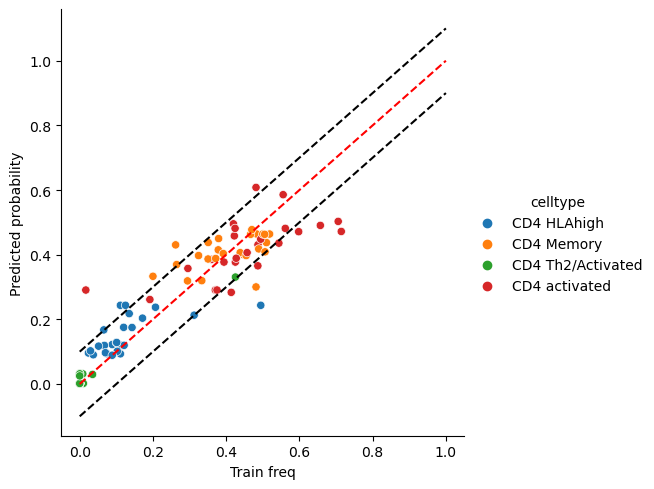

In [38]:
ident = np.linspace(0,1,100)
sns.relplot(data = df_join, x= "Train freq", y = "Predicted probability", hue = "celltype")
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

In [39]:
compute_pval(num_iter = 500, CD_type="CD4",
             prediction_results_df = res_1,
             true_data_df = test_CD4[test_CD4["CAR_Variant"]=="hCD28_h4-1BB"], epsilon = 1e-6)

OBSERVED: -33.321953285833885


0.724

In [40]:
validation_CD4

,Unnamed: 0,CD28,PI3K,Lck,Grb2,GADS,Akt,ERK12,GSK3b,CD3z,...,ADORA2A,TNFRSF4,KIR3DL1,GZMA,CD3E,RELA,IL16,CAR_Variant,Type,cell_type
4253,AAAGGTATCGGCCAAC-1-TCR,0.000000,0.000000,1.268152,1.268152,0.822920,0.000000,0.000000,0.000000,1.809691,...,0.0,0.000000,0.0,1.268152,1.268152,0.822920,0.822920,TCR-,CD4,CD4 Memory
4254,AAAGTCCTCACACGAT-1-TCR,0.753468,0.753468,0.753468,1.178257,0.753468,0.000000,0.000000,0.000000,2.047192,...,0.0,0.000000,0.0,0.000000,1.704278,1.178257,0.000000,TCR-,CD4,CD4 Memory
4255,AAAGTGATCACTGTTT-1-TCR,0.000000,0.803230,1.780187,0.000000,1.242852,0.000000,0.000000,0.803230,1.242852,...,0.0,0.000000,0.0,1.969028,1.242852,0.803230,0.000000,TCR-,CD4,CD4 Memory
4260,AACCAACAGTTGTAGA-1-TCR,0.391954,0.000000,1.576699,0.000000,0.672811,0.391954,1.071405,0.891838,1.671253,...,0.0,0.000000,0.0,3.721081,1.671253,0.891838,0.891838,TCR-,CD4,CD4 HLAhigh
4262,AACCATGTCGACGTCG-1-TCR,0.618631,0.618631,1.487392,0.997970,0.618631,0.000000,0.000000,0.000000,0.997970,...,0.0,0.000000,0.0,0.000000,1.945151,0.000000,0.618631,TCR-,CD4,CD4 Memory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,AGTTAGCGTAACCCTA-1-1,0.419250,0.231437,1.125994,1.282072,0.419250,0.231437,0.419250,0.000000,0.833800,...,0.0,1.738249,0.0,0.231437,1.282072,0.419250,0.231437,hIL15RA_hIL15RA,CD4,CD4 Th2/Activated
326,ATACTTCGTTTGGGTT-1-1,0.000000,0.506516,1.291434,0.284991,0.000000,0.000000,0.284991,0.000000,0.687758,...,0.0,0.506516,0.0,0.506516,1.887941,0.284991,0.506516,hIL15RA_hIL15RA,CD4,CD4 Memory
328,ATAGACCGTGGGTATG-1-1,0.000000,0.894893,1.529893,1.802495,0.544378,0.000000,0.000000,0.894893,1.802495,...,0.0,0.000000,0.0,0.000000,1.153924,0.894893,0.544378,hIL15RA_hIL15RA,CD4,CD4 activated
364,ATCGTGAAGGCGATAC-1-1,0.342903,0.342903,0.969310,1.113553,0.342903,0.000000,1.239588,0.000000,0.597772,...,0.0,0.000000,0.0,0.000000,1.239588,0.342903,0.342903,hIL15RA_hIL15RA,CD4,CD4 Th2/Activated


**On a small validation dataset, test that compute_likelihood_test_set works** IT DOES WORK

In [41]:
test_val = validation_CD4.iloc[[ 45, 139, 127,  91,  17, 197,  29, 171,  75,  44]][["CAR_Variant","cell_type", "Type"]]

In [42]:
test_val

,CAR_Variant,cell_type,Type
243,h4-1BB_hCD28,CD4 activated,CD4
348,hCTLA-4_hCTLA-4,CD4 Memory,CD4
79,hCD40_hIL15RA,CD4 Memory,CD4
110,hCD28_hIL15RA,CD4 Memory,CD4
4292,TCR-,CD4 Memory,CD4
140,hIL15RA_hIL15RA,CD4 Memory,CD4
342,h4-1BB_NA,CD4 HLAhigh,CD4
224,hIL15RA_hCD28,CD4 activated,CD4
89,hCD28_NA,CD4 Memory,CD4
191,h4-1BB_hCD28,CD4 activated,CD4


In [43]:
ll_observed = (
    np.log(0.395069)+np.log(0.368248)+np.log(0.395097)+np.log(0.424512)+
    np.log(0.477650)+np.log(0.273231)+np.log(0.196858)+np.log(0.414534)+
    np.log(0.420729) + np.log(0.395069)
)
ll_observed

-10.04978130762188

In [44]:
results_val[results_val["CAR Variant"]=="hCD40_hIL15RA"]

,CAR Variant,Type,Cell type,Predicted probability,True frequency
"(hCD40_hIL15RA, CD4 HLAhigh)",hCD40_hIL15RA,CD4,CD4 HLAhigh,0.117085,0.1
"(hCD40_hIL15RA, CD4 Memory)",hCD40_hIL15RA,CD4,CD4 Memory,0.386682,0.4
"(hCD40_hIL15RA, CD4 Th2/Activated)",hCD40_hIL15RA,CD4,CD4 Th2/Activated,0.025042,0.0
"(hCD40_hIL15RA, CD4 activated)",hCD40_hIL15RA,CD4,CD4 activated,0.471192,0.5


In [45]:
compute_likelihood_test_set(CD_type="CD4", true_data_df=test_val, predictions_results_df=results_val)

-9.955586020317822

**Manually compute the pvalue on this validation set**

In [46]:
p_vec_TCR = [0.454935, 0.477650, 0.000957,0.066458 ] # 1 draw
p_vec_41BB = [0.196858, 0.409958,0.000383, 0.392801]# 1 draw
p_vec_41BBCD28 = [0.142857, 0.461875, 0.000199, 0.395069] # 2 draw
p_vec_CD28 = [0.076969, 0.420729, 0.000323,0.501979 ] # 1 draw
p_vec_CD28_IL15RA = [0.104060, 0.424512, 0.009002, 0.462426]# 1 draw
p_vec_CD40_IL15RA = [0.116501, 0.395097, 0.008632,0.479770 ] # 1 draw
p_vec_CDLA4CTLA4 = [0.132620, 0.368248, 0.000325, 0.498807]
p_vec_IL15RACd28 = [0.082300, 0.491214, 0.011952, 0.414534]
p_vec_IL15RAIL155RA = [0.095232,0.273231, 0.395720, 0.235817 ]

vector_list = [p_vec_TCR, p_vec_41BB,p_vec_41BBCD28, p_vec_41BBCD28,
              p_vec_CD28,p_vec_CD28_IL15RA, p_vec_CD40_IL15RA, p_vec_CDLA4CTLA4, 
              p_vec_IL15RACd28,p_vec_IL15RAIL155RA ]

In [47]:
def compute_drawn_ll(vector_list):
    ll = 0
    for vector in vector_list:
        draw = np.random.choice(p = vector, size = 1, a = [0,1,2,3])[0]
        ll+= np.log(vector[draw])
    print(ll)
    return(ll)

In [48]:
pval = 0
for i in range(10000):
    ll = compute_drawn_ll(vector_list)
    print(ll)
    if ll<ll_observed:
        pval+=1
pval/10000

-8.619538372905849
-8.619538372905849
-10.76851739742567
-10.76851739742567
-9.935444310934836
-9.935444310934836
-10.372529691238597
-10.372529691238597
-10.056756851118344
-10.056756851118344
-8.182580815587661
-8.182580815587661
-8.8849009556046
-8.8849009556046
-9.264442223949198
-9.264442223949198
-8.329534025442609
-8.329534025442609
-8.827172166620015
-8.827172166620015
-10.482273962169842
-10.482273962169842
-11.455761404526056
-11.455761404526056
-11.475606865113251
-11.475606865113251
-10.890536085202704
-10.890536085202704
-8.558587997958508
-8.558587997958508
-9.616778952617366
-9.616778952617366
-11.90511223796314
-11.90511223796314
-10.553275907919085
-10.553275907919085
-8.311189986037462
-8.311189986037462
-13.369746440771216
-13.369746440771216
-11.554661812054768
-11.554661812054768
-10.897598309205092
-10.897598309205092
-9.807281886348711
-9.807281886348711
-11.655776219302355
-11.655776219302355
-10.49784526942182
-10.49784526942182
-10.722221429016178
-10.72222142

-8.485767883955043
-8.485767883955043
-8.897859754884426
-8.897859754884426
-10.475106345074312
-10.475106345074312
-13.31282074836194
-13.31282074836194
-10.946539996878126
-10.946539996878126
-10.330382222325884
-10.330382222325884
-10.407467163593498
-10.407467163593498
-11.268082890734668
-11.268082890734668
-12.772173699993777
-12.772173699993777
-9.426618914398661
-9.426618914398661
-11.687543365714578
-11.687543365714578
-10.548015184523221
-10.548015184523221
-8.64099296396559
-8.64099296396559
-10.485357534851861
-10.485357534851861
-13.08555558202762
-13.08555558202762
-9.253897987434256
-9.253897987434256
-16.350187096050018
-16.350187096050018
-8.748503127365048
-8.748503127365048
-9.370044575123154
-9.370044575123154
-9.616778952617366
-9.616778952617366
-10.688836687586772
-10.688836687586772
-8.595410573093554
-8.595410573093554
-11.27617861099925
-11.27617861099925
-10.249813284765825
-10.249813284765825
-8.778263175106408
-8.778263175106408
-9.510463374576435
-9.510463

-13.2880565265468
-13.2880565265468
-12.171317293606544
-12.171317293606544
-11.70444781905896
-11.70444781905896
-9.118674264226504
-9.118674264226504
-9.078358834869748
-9.078358834869748
-9.18623571587931
-9.18623571587931
-9.11928054141658
-9.11928054141658
-10.480610264878711
-10.480610264878711
-8.837986948324906
-8.837986948324906
-9.406079420916138
-9.406079420916138
-9.853606412536772
-9.853606412536772
-9.422136887379764
-9.422136887379764
-11.57004982184003
-11.57004982184003
-8.622029316593974
-8.622029316593974
-10.215571377935937
-10.215571377935937
-9.359086732796992
-9.359086732796992
-10.073991987395114
-10.073991987395114
-10.40899651109746
-10.40899651109746
-12.197313803164917
-12.197313803164917
-9.6645232933303
-9.6645232933303
-11.568152833848414
-11.568152833848414
-8.463308713514905
-8.463308713514905
-10.176035302290437
-10.176035302290437
-8.31220342739985
-8.31220342739985
-8.571901016065912
-8.571901016065912
-10.996057443997119
-10.996057443997119
-10.0433

-8.584087657082263
-8.584087657082263
-9.241224135784613
-9.241224135784613
-8.448945308819997
-8.448945308819997
-11.97698283095829
-11.97698283095829
-11.15469955430127
-11.15469955430127
-10.135449195719191
-10.135449195719191
-8.182580815587661
-8.182580815587661
-9.104808655943218
-9.104808655943218
-8.547483124451471
-8.547483124451471
-9.859222930515543
-9.859222930515543
-11.622178845151021
-11.622178845151021
-9.424120857857517
-9.424120857857517
-11.430863754766312
-11.430863754766312
-10.669281863098458
-10.669281863098458
-11.598460772193839
-11.598460772193839
-12.00462132573795
-12.00462132573795
-9.538216860538084
-9.538216860538084
-9.635921337484984
-9.635921337484984
-9.896107849955577
-9.896107849955577
-11.909569111105789
-11.909569111105789
-11.672741651186385
-11.672741651186385
-8.770886467703157
-8.770886467703157
-11.285444726542615
-11.285444726542615
-11.743781781511544
-11.743781781511544
-8.434000859063847
-8.434000859063847
-8.625790228801385
-8.6257902288

-9.599844752279171
-9.599844752279171
-9.576158520049797
-9.576158520049797
-8.541336063957452
-8.541336063957452
-9.642213849267177
-9.642213849267177
-8.275380852264805
-8.275380852264805
-11.242632215558158
-11.242632215558158
-8.401029391006716
-8.401029391006716
-10.454738092287613
-10.454738092287613
-12.183489099329073
-12.183489099329073
-11.793156370307727
-11.793156370307727
-12.305015990876681
-12.305015990876681
-13.729162154993755
-13.729162154993755
-9.95786039737657
-9.95786039737657
-9.012666596463614
-9.012666596463614
-8.377725498041766
-8.377725498041766
-8.706170981426913
-8.706170981426913
-11.892272562067724
-11.892272562067724
-10.626716969881812
-10.626716969881812
-10.51980916257325
-10.51980916257325
-8.244795532494281
-8.244795532494281
-12.367602547281212
-12.367602547281212
-8.13982922246285
-8.13982922246285
-10.310491441569612
-10.310491441569612
-9.55170788233173
-9.55170788233173
-11.310771947643788
-11.310771947643788
-8.489569039066255
-8.489569039066

-7.96598921112178
-7.96598921112178
-8.880705795346092
-8.880705795346092
-8.966918956680479
-8.966918956680479
-9.78354105146762
-9.78354105146762
-12.08826633917985
-12.08826633917985
-10.183153457685057
-10.183153457685057
-9.41013184594669
-9.41013184594669
-8.12815208762398
-8.12815208762398
-12.622142848144472
-12.622142848144472
-10.302656310035283
-10.302656310035283
-8.279576012523314
-8.279576012523314
-11.356695188434038
-11.356695188434038
-13.095314320307564
-13.095314320307564
-12.489740917545333
-12.489740917545333
-10.153812857130374
-10.153812857130374
-9.69384270495949
-9.69384270495949
-10.633895604651524
-10.633895604651524
-9.484540496584051
-9.484540496584051
-8.573710703899195
-8.573710703899195
-12.292669768260351
-12.292669768260351
-11.437708239655741
-11.437708239655741
-9.705296749953574
-9.705296749953574
-13.067141100848824
-13.067141100848824
-10.711879871095666
-10.711879871095666
-9.75258515001735
-9.75258515001735
-12.276196083299558
-12.27619608329955

-9.183748971312674
-9.183748971312674
-8.812002177559433
-8.812002177559433
-9.776334088251163
-9.776334088251163
-11.724353946257223
-11.724353946257223
-10.064253193095242
-10.064253193095242
-11.284511622092438
-11.284511622092438
-8.06777397400847
-8.06777397400847
-11.717278586480857
-11.717278586480857
-10.559549584134137
-10.559549584134137
-10.305236978340442
-10.305236978340442
-10.140369118456622
-10.140369118456622
-12.262938952512464
-12.262938952512464
-9.346588784703677
-9.346588784703677
-13.728458371902404
-13.728458371902404
-7.96598921112178
-7.96598921112178
-10.25574230275559
-10.25574230275559
-11.498070234674879
-11.498070234674879
-9.28686775220499
-9.28686775220499
-10.89687019257039
-10.89687019257039
-8.638162166218365
-8.638162166218365
-14.678987416575884
-14.678987416575884
-10.003986384718852
-10.003986384718852
-11.42686342509213
-11.42686342509213
-10.476701985439043
-10.476701985439043
-10.485357534851861
-10.485357534851861
-8.795515109107464
-8.795515

-10.423425693000347
-10.423425693000347
-12.796895168304202
-12.796895168304202
-10.986985322097475
-10.986985322097475
-11.821715902333759
-11.821715902333759
-12.122560852389942
-12.122560852389942
-12.34867167348813
-12.34867167348813
-12.27990777261509
-12.27990777261509
-7.9943773995516825
-7.9943773995516825
-9.051965750518308
-9.051965750518308
-8.34067164505327
-8.34067164505327
-10.765918206652062
-10.765918206652062
-12.604097343567732
-12.604097343567732
-11.159954708742822
-11.159954708742822
-11.646709512092606
-11.646709512092606
-11.817536559206518
-11.817536559206518
-8.309554102768928
-8.309554102768928
-12.501742898273871
-12.501742898273871
-10.563313115570335
-10.563313115570335
-14.20378701048847
-14.20378701048847
-11.265182593271685
-11.265182593271685
-8.992060197855164
-8.992060197855164
-10.239359127378396
-10.239359127378396
-11.654304093187312
-11.654304093187312
-18.410075581674313
-18.410075581674313
-11.464190806832837
-11.464190806832837
-11.170333007647

-8.206401679692268
-8.206401679692268
-11.707725115399045
-11.707725115399045
-10.277863901034056
-10.277863901034056
-8.642357326476871
-8.642357326476871
-12.754567547165143
-12.754567547165143
-8.057464499359568
-8.057464499359568
-9.788035865840937
-9.788035865840937
-11.831796404145734
-11.831796404145734
-9.983048921671147
-9.983048921671147
-13.7756363316091
-13.7756363316091
-11.664210236617851
-11.664210236617851
-9.123152815192913
-9.123152815192913
-8.819690192039653
-8.819690192039653
-11.742297672303847
-11.742297672303847
-10.804881975442054
-10.804881975442054
-10.241759911806618
-10.241759911806618
-8.818972553280656
-8.818972553280656
-8.964424376191824
-8.964424376191824
-10.194959458616777
-10.194959458616777
-8.996212274115269
-8.996212274115269
-9.924294000801181
-9.924294000801181
-8.860273679382109
-8.860273679382109
-9.853393563755331
-9.853393563755331
-8.832014846336739
-8.832014846336739
-8.273603910535147
-8.273603910535147
-8.321972021638729
-8.321972021638

-9.102099669750839
-9.102099669750839
-9.18623571587931
-9.18623571587931
-8.054282952214827
-8.054282952214827
-10.018425524088588
-10.018425524088588
-10.461836873694033
-10.461836873694033
-9.849264463657043
-9.849264463657043
-10.048628384750138
-10.048628384750138
-9.42216963348339
-9.42216963348339
-11.501471671307737
-11.501471671307737
-9.256923304143719
-9.256923304143719
-10.497070238225744
-10.497070238225744
-8.23049673340094
-8.23049673340094
-12.494886782055682
-12.494886782055682
-12.609415449620206
-12.609415449620206
-8.60305130445388
-8.60305130445388
-10.151009975752213
-10.151009975752213
-8.766771336668166
-8.766771336668166
-8.989367789225838
-8.989367789225838
-8.824818764437032
-8.824818764437032
-10.36717108348949
-10.36717108348949
-8.601339591083319
-8.601339591083319
-10.266352713343066
-10.266352713343066
-13.535201562916178
-13.535201562916178
-11.420957383264184
-11.420957383264184
-8.766767137546676
-8.766767137546676
-8.975924050552086
-8.97592405055208

-8.590234717576282
-8.590234717576282
-8.748284965016245
-8.748284965016245
-9.794323087068886
-9.794323087068886
-9.544289903053157
-9.544289903053157
-8.511995463402767
-8.511995463402767
-9.788182800190384
-9.788182800190384
-8.829854237354562
-8.829854237354562
-10.044134784259297
-10.044134784259297
-10.355380704212092
-10.355380704212092
-9.50926878921791
-9.50926878921791
-13.797542448008329
-13.797542448008329
-10.005432262009256
-10.005432262009256
-8.741658642475617
-8.741658642475617
-8.46327176828979
-8.46327176828979
-9.329778878345936
-9.329778878345936
-10.074524209908935
-10.074524209908935
-8.576194150787144
-8.576194150787144
-10.18648658725899
-10.18648658725899
-14.325695498269953
-14.325695498269953
-9.510430628472811
-9.510430628472811
-8.297840022704943
-8.297840022704943
-10.946512063010982
-10.946512063010982
-10.328505629366672
-10.328505629366672
-8.711013661143637
-8.711013661143637
-8.677815539100637
-8.677815539100637
-8.860273679382109
-8.860273679382109


-9.145368390887688
-9.145368390887688
-11.151612351864348
-11.151612351864348
-9.595976898720835
-9.595976898720835
-10.514977326992954
-10.514977326992954
-9.309164253204003
-9.309164253204003
-8.092919414304644
-8.092919414304644
-7.838143541039248
-7.838143541039248
-10.876794817788646
-10.876794817788646
-11.5097860659387
-11.5097860659387
-10.214362568942237
-10.214362568942237
-11.595189746686994
-11.595189746686994
-9.654365028119683
-9.654365028119683
-8.445105732570884
-8.445105732570884
-12.749016098915286
-12.749016098915286
-10.554381305980591
-10.554381305980591
-8.334699543065103
-8.334699543065103
-8.614014999655243
-8.614014999655243
-9.840177191626143
-9.840177191626143
-8.545096976164862
-8.545096976164862
-10.399645410921385
-10.399645410921385
-10.837973455106441
-10.837973455106441
-8.7895860911177
-8.7895860911177
-8.759252416862688
-8.759252416862688
-9.27631407387599
-9.27631407387599
-11.669263161819059
-11.669263161819059
-10.298271486496665
-10.29827148649666

-14.214760112384766
-14.214760112384766
-8.601241616620596
-8.601241616620596
-8.357745575368087
-8.357745575368087
-8.897859754884426
-8.897859754884426
-11.094913235032703
-11.094913235032703
-8.037128992676493
-8.037128992676493
-13.18710838995442
-13.18710838995442
-9.507312167035183
-9.507312167035183
-9.825420261691168
-9.825420261691168
-10.498102352005388
-10.498102352005388
-9.045121265628877
-9.045121265628877
-9.268063637849508
-9.268063637849508
-10.13439604860064
-10.13439604860064
-8.266759425645715
-8.266759425645715
-10.460310069018409
-10.460310069018409
-9.960552806005893
-9.960552806005893
-8.372641202576814
-8.372641202576814
-9.507312167035183
-9.507312167035183
-8.8179742795476
-8.8179742795476
-9.590330375358251
-9.590330375358251
-9.77603315231259
-9.77603315231259
-9.441888554688793
-9.441888554688793
-9.931215436704887
-9.931215436704887
-9.532600342559313
-9.532600342559313
-10.301637482018771
-10.301637482018771
-8.407518291886753
-8.407518291886753
-12.1679

-8.478561464160558
-8.478561464160558
-9.916885745981416
-9.916885745981416
-9.337552441633903
-9.337552441633903
-11.251848428386031
-11.251848428386031
-10.174868815792918
-10.174868815792918
-10.250765005678227
-10.250765005678227
-8.42680477716414
-8.42680477716414
-8.489528796162453
-8.489528796162453
-8.491696901944808
-8.491696901944808
-9.564102795910527
-9.564102795910527
-9.551121057166192
-9.551121057166192
-9.003694248695632
-9.003694248695632
-12.32603126408141
-12.32603126408141
-8.16410227985776
-8.16410227985776
-10.044731416063948
-10.044731416063948
-8.724504682937283
-8.724504682937283
-11.680526064374
-11.680526064374
-8.757573449595752
-8.757573449595752
-11.296300135556027
-11.296300135556027
-10.588364094810625
-10.588364094810625
-9.76903741007143
-9.76903741007143
-12.692809247483389
-12.692809247483389
-12.136125119554142
-12.136125119554142
-8.975844021328568
-8.975844021328568
-8.98340602513245
-8.98340602513245
-8.467423844549897
-8.467423844549897
-9.83606

-10.165299128297443
-10.165299128297443
-12.03404901461951
-12.03404901461951
-12.012014962599148
-12.012014962599148
-11.62254894136749
-11.62254894136749
-10.689514545840524
-10.689514545840524
-9.026639093098446
-9.026639093098446
-8.530554028356185
-8.530554028356185
-9.854671029074794
-9.854671029074794
-10.53099765728282
-10.53099765728282
-8.93761110222942
-8.93761110222942
-9.917961781970282
-9.917961781970282
-9.111297556823253
-9.111297556823253
-9.711448857788126
-9.711448857788126
-8.535363961969285
-8.535363961969285
-9.553549117581527
-9.553549117581527
-12.51625187688028
-12.51625187688028
-13.68311578919764
-13.68311578919764
-9.84171642891646
-9.84171642891646
-9.098694341552825
-9.098694341552825
-14.717930752083063
-14.717930752083063
-9.897469905319499
-9.897469905319499
-9.703966883207764
-9.703966883207764
-9.494835358249336
-9.494835358249336
-8.213698357872003
-8.213698357872003
-12.199769316185717
-12.199769316185717
-8.6398411334853
-8.6398411334853
-11.445227

-11.472309979560716
-11.472309979560716
-10.191146451052992
-10.191146451052992
-10.693022697979549
-10.693022697979549
-11.151546414606235
-11.151546414606235
-14.158451437306091
-14.158451437306091
-8.557263249519151
-8.557263249519151
-10.414531562332801
-10.414531562332801
-11.518758413706685
-11.518758413706685
-11.321756932547192
-11.321756932547192
-8.115378584744782
-8.115378584744782
-11.739507817318733
-11.739507817318733
-9.85436991290404
-9.85436991290404
-9.922405482431492
-9.922405482431492
-13.033645604251424
-13.033645604251424
-9.180263613891142
-9.180263613891142
-9.403946895177082
-9.403946895177082
-10.177191693591666
-10.177191693591666
-10.223027917282028
-10.223027917282028
-10.856676810622359
-10.856676810622359
-12.639641876644655
-12.639641876644655
-8.759285162966313
-8.759285162966313
-8.40706609859645
-8.40706609859645
-9.581112478188201
-9.581112478188201
-9.94997038507087
-9.94997038507087
-12.032689587922745
-12.032689587922745
-9.175346481133301
-9.1753

-10.946562768412265
-10.946562768412265
-12.662028827364699
-12.662028827364699
-10.761411089804533
-10.761411089804533
-12.098026265502838
-12.098026265502838
-12.7498713909487
-12.7498713909487
-12.51839655379421
-12.51839655379421
-10.178200788844002
-10.178200788844002
-10.674908442480971
-10.674908442480971
-11.752990594368066
-11.752990594368066
-8.719694749324184
-8.719694749324184
-9.272261648845436
-9.272261648845436
-8.728134874578346
-8.728134874578346
-11.517496078286648
-11.517496078286648
-7.746625168803057
-7.746625168803057
-10.022395869487895
-10.022395869487895
-9.845731908721898
-9.845731908721898
-11.143684213265571
-11.143684213265571
-15.087564044132973
-15.087564044132973
-10.585363849030811
-10.585363849030811
-8.032319059063393
-8.032319059063393
-12.092003342908527
-12.092003342908527
-9.482075186146535
-9.482075186146535
-7.908831129303659
-7.908831129303659
-10.556908632572874
-10.556908632572874
-8.188552917575828
-8.188552917575828
-8.098891516292811
-8.09

-14.941285972388634
-14.941285972388634
-8.728667097092167
-8.728667097092167
-9.950246025463029
-9.950246025463029
-9.765719430628755
-9.765719430628755
-9.826297935146675
-9.826297935146675
-11.213532213316192
-11.213532213316192
-14.341931446022802
-14.341931446022802
-9.114151197373792
-9.114151197373792
-10.09750753620748
-10.09750753620748
-9.624652311411657
-9.624652311411657
-12.396671236377006
-12.396671236377006
-10.538567506049425
-10.538567506049425
-11.40143397639599
-11.40143397639599
-7.860107434190681
-7.860107434190681
-8.362635538204701
-8.362635538204701
-10.356323113387022
-10.356323113387022
-9.888839085856103
-9.888839085856103
-9.962890090189804
-9.962890090189804
-8.26260734938561
-8.26260734938561
-9.58796092802839
-9.58796092802839
-9.821928331575773
-9.821928331575773
-8.659293919372335
-8.659293919372335
-8.770966496926675
-8.770966496926675
-8.539657096690513
-8.539657096690513
-12.961416336521408
-12.961416336521408
-10.495299982239334
-10.495299982239334


-8.115378584744782
-8.115378584744782
-12.32916163894099
-12.32916163894099
-11.363137221787214
-11.363137221787214
-8.797226822478025
-8.797226822478025
-10.07323447881257
-10.07323447881257
-9.24560026828788
-9.24560026828788
-8.39854594411877
-8.39854594411877
-12.607402466663116
-12.607402466663116
-12.571776378080674
-12.571776378080674
-9.250078819254288
-9.250078819254288
-9.210126961162333
-9.210126961162333
-8.522991904707757
-8.522991904707757
-8.638162166218365
-8.638162166218365
-9.946193600432474
-9.946193600432474
-8.819690192039653
-8.819690192039653
-10.17647405483267
-10.17647405483267
-9.42260343459322
-9.42260343459322
-8.029832314496758
-8.029832314496758
-12.205559200436431
-12.205559200436431
-9.490382346050655
-9.490382346050655
-8.485767883955043
-8.485767883955043
-10.7195415261291
-10.7195415261291
-10.177081704467337
-10.177081704467337
-11.13260816631449
-11.13260816631449
-10.486070040275676
-10.486070040275676
-10.147887070394285
-10.147887070394285
-8.121

-9.239675449419606
-9.239675449419606
-8.896264114519694
-8.896264114519694
-9.794510157067776
-9.794510157067776
-12.247633138642627
-12.247633138642627
-9.471290184481084
-9.471290184481084
-8.748284965016245
-8.748284965016245
-11.328378100472424
-11.328378100472424
-8.09288246907953
-8.09288246907953
-9.123152815192913
-9.123152815192913
-10.17546061347028
-10.17546061347028
-9.20285287428456
-9.20285287428456
-8.391249265939036
-8.391249265939036
-8.896264114519694
-8.896264114519694
-8.371236597161731
-8.371236597161731
-10.179071762603366
-10.179071762603366
-9.552063466341124
-9.552063466341124
-12.140222546039693
-12.140222546039693
-9.270385055886226
-9.270385055886226
-10.474681246888947
-10.474681246888947
-10.025510990946781
-10.025510990946781
-8.454073881217376
-8.454073881217376
-11.048988920047831
-11.048988920047831
-9.005551219648808
-9.005551219648808
-8.512028209506393
-8.512028209506393
-10.423991177270583
-10.423991177270583
-9.8124085744654
-9.8124085744654
-9.9

-9.138523905998255
-9.138523905998255
-9.87794217593612
-9.87794217593612
-14.524712299250078
-14.524712299250078
-10.903199974971013
-10.903199974971013
-7.929166635986734
-7.929166635986734
-11.669148360458248
-11.669148360458248
-10.474003313886113
-10.474003313886113
-8.844798687110712
-8.844798687110712
-8.363087731495005
-8.363087731495005
-9.402156964706085
-9.402156964706085
-9.095249566156939
-9.095249566156939
-10.843284454503815
-10.843284454503815
-9.365117344273282
-9.365117344273282
-10.65352894483023
-10.65352894483023
-11.419854825343219
-11.419854825343219
-11.091794775220917
-11.091794775220917
-10.996722900057902
-10.996722900057902
-11.264723524751751
-11.264723524751751
-12.95423119362447
-12.95423119362447
-8.420477091166576
-8.420477091166576
-9.328982631875041
-9.328982631875041
-9.802471952735612
-9.802471952735612
-9.638808521069162
-9.638808521069162
-8.144639156075948
-8.144639156075948
-9.4928572217478
-9.4928572217478
-9.59041040458177
-9.59041040458177
-1

-10.493757697255361
-10.493757697255361
-8.468437285912286
-8.468437285912286
-9.798297981402596
-9.798297981402596
-11.618247950250558
-11.618247950250558
-10.945086762621179
-10.945086762621179
-9.038974205134858
-9.038974205134858
-11.016710926084304
-11.016710926084304
-8.944088869508747
-8.944088869508747
-11.070785435220404
-11.070785435220404
-11.890051310883226
-11.890051310883226
-8.057464499359568
-8.057464499359568
-11.89012540427705
-11.89012540427705
-8.406469270481065
-8.406469270481065
-11.609030007597509
-11.609030007597509
-9.81178900319624
-9.81178900319624
-11.284511622092438
-11.284511622092438
-11.673228694981887
-11.673228694981887
-12.717259885201457
-12.717259885201457
-8.596206819564449
-8.596206819564449
-8.996179528011645
-8.996179528011645
-9.21933994273653
-9.21933994273653
-7.908831129303659
-7.908831129303659
-13.614781508249875
-13.614781508249875
-8.714821856470941
-8.714821856470941
-11.065177805318758
-11.065177805318758
-8.809598759895005
-8.80959875

0.447

In [49]:
# Compare to pval found using the code
compute_pval(num_iter=10000, true_data_df=test_val, prediction_results_df=results_val, CD_type = "CD4")

OBSERVED: -9.955586020317822


0.6884

**This also seems validated**